# 4d. Predict emergency demand for sub-groups

In the previous notebook I demonstrated how we evaluate the models used at UCLH. As a final step, I now show the same implementation in code, but including extra functionality to handle certain sub-groups differently from others. 

At UCLH, it is standard practice to admit paediatric patients (defined as patients under 18 on the day of arrival at the ED) to paediatric wards, and not to admit adult patients (18 or over) to paediatric wards. 

The two models that enable prediction by sub-groups (specialty of admission, and yet-to-arrive by specialty) offer parameters that allow you to specify that certain groups are handled differently. In the UCLH example, this means disregarding any consult requests for patients in the ED when predicting which specialty they will be admitted to, and counting all yet-to-arrive patients under 18 as paediatric admissions. 

Most of the code below is the same as in the previous notebook. I limit the narrative here to pointing out how the special sub-groups are handled. 

In [3]:
# Reload functions every time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data and train models

The data loading, configuration, and model training steps are identical to those demonstrated in detail in [notebook 4b](4b_Predict_emergency_demand.ipynb). Here we use `prepare_prediction_inputs` to perform all of these steps in a single call.

You can request the UCLH datasets on [Zenodo](https://zenodo.org/records/14866057). If you don't have the public data, change `data_folder_name` from `'data-public'` to `'data-synthetic'`.

In [4]:
from patientflow.train.emergency_demand import prepare_prediction_inputs

data_folder_name = 'data-public'
prediction_inputs = prepare_prediction_inputs(data_folder_name)

# Unpack the results
admissions_models = prediction_inputs['admission_models']
spec_model = prediction_inputs['specialty_model']
yta_model_by_spec = prediction_inputs['yta_model']
ed_visits = prediction_inputs['ed_visits']
inpatient_arrivals = prediction_inputs['inpatient_arrivals']
specialties = prediction_inputs['specialties']
params = prediction_inputs['config']

/Users/zellaking/Repos/patientflow/src/patientflow/train/emergency_demand.py:470: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ed_visits["snapshot_date"] = pd.to_datetime(


Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]

Processing: (6, 0)

Processing: (9, 30)

Processing: (12, 0)

Processing: (15, 30)

Processing: (22, 0)


In [5]:
import pandas as pd
from datetime import timedelta
from patientflow.prepare import create_temporal_splits
from patientflow.load import get_model_key

model_name = 'admissions'

# Extract config parameters
start_training_set = params['start_training_set']
start_validation_set = params['start_validation_set']
start_test_set = params['start_test_set']
end_test_set = params['end_test_set']
prediction_window = timedelta(minutes=params['prediction_window'])
x1, y1, x2, y2 = params['x1'], params['y1'], params['x2'], params['y2']
yta_time_interval = timedelta(minutes=params['yta_time_interval'])

# Create temporal splits for the ED visits
train_visits_df, valid_visits_df, test_visits_df = create_temporal_splits(
    ed_visits, start_training_set, start_validation_set,
    start_test_set, end_test_set, col_name='snapshot_date',
)

# Create temporal splits for inpatient arrivals
inpatient_arrivals['arrival_datetime'] = pd.to_datetime(
    inpatient_arrivals['arrival_datetime'], utc=True
)
train_inpatient_arrivals_df, _, test_inpatient_arrivals_df = create_temporal_splits(
    inpatient_arrivals, start_training_set, start_validation_set,
    start_test_set, end_test_set, col_name='arrival_datetime',
)

# Define columns excluded from training data (needed by evaluation functions)
exclude_from_training_data = [
    'snapshot_date', 'prediction_time', 'visit_number',
    'consultation_sequence', 'specialty', 'final_sequence',
]

Split sizes: [62071, 10415, 29134]
Split sizes: [7716, 1285, 3898]


## Explore the cohort-aware specialty model

The `prepare_prediction_inputs` function trained a `MultiSubgroupPredictor` for specialty prediction. This model handles paediatric and adult patients as separate cohorts, each with their own `SequenceToOutcomePredictor`. Let's explore how it works.

The `MultiSubgroupPredictor` was configured with subgroup functions that identify paediatric patients (age group 0-17) and adult patients, then trains separate specialty predictors for each subgroup.

In [6]:
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor
from patientflow.predictors.subgroup_predictor import MultiSubgroupPredictor

def create_subgroup_functions_from_age_group():
    """Create subgroup functions that work with age_group categorical variable."""
    
    def is_paediatric(row):
        return row.get("age_group") == "0-17"
    
    def is_adult(row):
        # All non-paediatric patients are adults
        return row.get("age_group") != "0-17"
    
    return {
        "paediatric": is_paediatric,
        "adult": is_adult,
    }

subgroup_functions = create_subgroup_functions_from_age_group()

spec_model = MultiSubgroupPredictor(
    subgroup_functions=subgroup_functions,
    base_predictor_class=SequenceToOutcomePredictor,
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    min_samples=50,  # Minimum samples required per subgroup
)
spec_model = spec_model.fit(train_visits_df)

By training on the data, we have derived the following mapping. The intended containment of children to paediatric specialties only, and excluding adults form paediatric specialties did not work as intended. That is because `infer_specialty_to_subgroups` function includes any subgroup that appears **at least once** for a specialty in the training data. This means that a few edge cases (e.g., an adult patient incorrectly coded as being admitted to paediatric specialty, or vice versa, or a legitimate reason for breaking the usual policy), both subgroups will be included.

In [7]:
spec_model.specialty_to_subgroups

{'medical': ['paediatric', 'adult'],
 'surgical': ['paediatric', 'adult'],
 'paediatric': ['paediatric', 'adult'],
 'haem/onc': ['paediatric', 'adult']}

Looking at the actual subgroup mapping in the data, we see that some children do go to adult specialties and vice versa. From the data below, 3% of children were admitted to surgical specialties; these might be genuine decisions rather than coding errors.

In [8]:

for specialty in spec_model.specialty_to_subgroups.keys():
    spec_mask = train_visits_df['specialty'] == specialty
    spec_data = train_visits_df[spec_mask]
    
    paediatric_count = spec_data.apply(subgroup_functions['paediatric'], axis=1).sum()
    adult_count = spec_data.apply(subgroup_functions['adult'], axis=1).sum()
    total = len(spec_data)
    
    print(f"\n{specialty} specialty:")
    print(f"  Total patients: {total}")
    print(f"  Paediatric (age_group == '0-17'): {paediatric_count} ({paediatric_count/total*100:.1f}%)")
    print(f"  Adult (age_group != '0-17'): {adult_count} ({adult_count/total*100:.1f}%)")
    
    # Check for missing age_group values
    missing_age = spec_data['age_group'].isna().sum()
    if missing_age > 0:
        print(f"  Missing age_group: {missing_age} ({missing_age/total*100:.1f}%)")


medical specialty:
  Total patients: 5392
  Paediatric (age_group == '0-17'): 12 (0.2%)
  Adult (age_group != '0-17'): 5380 (99.8%)

surgical specialty:
  Total patients: 2185
  Paediatric (age_group == '0-17'): 70 (3.2%)
  Adult (age_group != '0-17'): 2115 (96.8%)

paediatric specialty:
  Total patients: 528
  Paediatric (age_group == '0-17'): 513 (97.2%)
  Adult (age_group != '0-17'): 15 (2.8%)

haem/onc specialty:
  Total patients: 707
  Paediatric (age_group == '0-17'): 1 (0.1%)
  Adult (age_group != '0-17'): 706 (99.9%)


We can override this mapping if we wished to enforce stricter policy rules, as shown below.

In [9]:
expected_mapping = {
    'paediatric': ['paediatric'],
    'medical': ['adult'],
    'surgical': ['adult'],
    'haem/onc': ['adult'],
}

# Override the inferred mapping
spec_model.specialty_to_subgroups = expected_mapping

print("Updated specialty_to_subgroups mapping:")
spec_model.specialty_to_subgroups

Updated specialty_to_subgroups mapping:


{'paediatric': ['paediatric'],
 'medical': ['adult'],
 'surgical': ['adult'],
 'haem/onc': ['adult']}

## Generate predicted distributions for each specialty and prediction time for patients in ED

Now that the models have been trained with the special parameters, we proceed with generating and evaluating predictions. The approach below uses a similar function to the `get_specialty_probability_distributions` function shown in the previous notebook, with some additional logic to identify sub-groups that need special processing. 

The function 

* retrieves the special parameters than were saved with the specialty predictor
* ensures that only eligible patient snapshots are included in the predictions for each specialty. A temporary version of the test set, called `test_df_eligible` is created for each iteration through the various specialties using only the eligible visits 

Why is this necessary? Imagine an ED that currently has 75 adult patients and 25 children. Tje maximum number of beds that could be needed in the paediatric specialties is 25 and the maximum number of beds that could be needed in the adult specialties is 75. Without filtering a probabilty distribution for 100 beds would be produced. The logic below means that adult patients are excluded from the predicted distribution for the paediatric specialty, and children from the predicted distributions for the adult specialty. 



In [12]:
from patientflow.prepare import prepare_patient_snapshots, prepare_group_snapshot_dict
from patientflow.aggregate import get_prob_dist
from patientflow.predict.emergency_demand import get_specialty_probs
from patientflow.load import get_model_key


def get_specialty_probability_distributions_with_special_categories(
    test_visits_df,
    spec_model,
    admissions_models,
    model_name,
    exclude_from_training_data,
    specialties=['medical', 'surgical', 'haem/onc', 'paediatric'],
    baseline_prob_dict=None,
):
    """
    Calculate probability distributions for emergency department patients by specialty and prediction time.
    
    Args:
        test_visits_df: DataFrame containing test visit data
        spec_model: Model for specialty predictions (SequenceToOutcomePredictor)
        admissions_models: Dictionary of admission prediction models
        model_name: Name of the model to use
        specialties: List of specialties to consider
        exclude_from_training_data: List of columns to exclude from training data
        baseline_prob_dict: Optional dict of baseline probabilities to use instead of spec_model predictions
        
    Returns:
        Dictionary containing probability distributions for each specialty and prediction time
    """
    # Get specialty prediction parameters
    special_params = spec_model.special_params
    special_category_func = special_params["special_category_func"]
    special_category_dict = special_params["special_category_dict"]
    special_func_map = special_params["special_func_map"]

    # Get predictions of admission to specialty
    if baseline_prob_dict is not None:
        # Use baseline probabilities instead of model predictions
        # Create paediatric dictionary for age group 0-17
        paediatric_dict = {key: 0 for key in baseline_prob_dict.keys()}
        paediatric_dict['paediatric'] = 1
        
        # Apply different dictionaries based specialty category function
        test_visits_df.loc[:, "specialty_prob"] = test_visits_df.apply(
            lambda row: paediatric_dict if special_category_func(row) else baseline_prob_dict,
            axis=1
        )
    else:
        # Use spec_model to get predictions
        test_visits_df.loc[:, "specialty_prob"] = get_specialty_probs(
            specialties,
            spec_model,
            test_visits_df,
            special_category_func=special_category_func,
            special_category_dict=special_category_dict,
        )

    # Initialize dictionary to store probability distributions
    prob_dist_dict_all = {}

    # Process each time of day
    for _prediction_time in test_visits_df.prediction_time.unique():
        prob_dist_dict_for_pats_in_ED = {}
        print("\nProcessing :" + str(_prediction_time))
        model_key = get_model_key(model_name, _prediction_time)
        
        for specialty in specialties:
            print(f"Predicting bed counts for {specialty} specialty, for all snapshots in the test set")
            
            # Get indices of patients who are eligible for this specialty
            func = special_func_map.get(specialty, special_func_map["default"])
            non_zero_indices = test_visits_df[
                test_visits_df.apply(func, axis=1)
            ].index

            test_df_eligible = test_visits_df.copy()
            test_df_eligible = test_df_eligible.loc[non_zero_indices]

            # Get probability of admission to specialty for eligible patients
            prob_admission_to_specialty = test_df_eligible["specialty_prob"].apply(
                lambda x: x[specialty]
            )
            
            # Prepare patient snapshots
            X_test, y_test = prepare_patient_snapshots(
                df=test_df_eligible, 
                prediction_time=_prediction_time, 
                single_snapshot_per_visit=False,
                exclude_columns=exclude_from_training_data, 
                visit_col='visit_number'
            )

            # Filter probabilities for eligible patients
            filtered_prob_admission_to_specialty = prob_admission_to_specialty.loc[
                non_zero_indices
            ]

            # Prepare group snapshots
            group_snapshots_dict = prepare_group_snapshot_dict(
                test_df_eligible[test_df_eligible.prediction_time == _prediction_time]
            )

            admitted_to_specialty = test_df_eligible['specialty'] == specialty

            # Get probability distribution for this time and specialty
            prob_dist_dict_for_pats_in_ED[specialty] = get_prob_dist(
                group_snapshots_dict, X_test, y_test, admissions_models[model_key], 
                weights=filtered_prob_admission_to_specialty,
                category_filter=admitted_to_specialty, 
                normal_approx_threshold=30
            )

        prob_dist_dict_all[f'{model_key}'] = prob_dist_dict_for_pats_in_ED

    return prob_dist_dict_all

In [13]:
prob_dist_dict_all = get_specialty_probability_distributions_with_special_categories(
    test_visits_df=test_visits_df,
    spec_model=spec_model,      
    admissions_models=admissions_models,
    model_name=model_name,
    exclude_from_training_data=exclude_from_training_data,
)


Processing :(22, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 

## Visualise the performance of emergency demand prediction models for patients in the ED

Below I generate EPUDD plots for each specialties, using both the baseline predictions, and the sequence predictor. The plots are very similar to the previous notebook. Using age as a fixed category for identifying patients destined for paediatric or adult wards yields similar results.

In [14]:
baseline_probs = train_inpatient_arrivals_df[~(train_inpatient_arrivals_df.is_child) & 
                                             (train_inpatient_arrivals_df.specialty.isin(['medical', 'surgical', 'haem/onc']))]['specialty'].value_counts(normalize=True).to_dict()
baseline_probs['paediatric'] = 0

prob_dist_dict_all_baseline = get_specialty_probability_distributions_with_special_categories(
    test_visits_df=test_visits_df,
    spec_model=spec_model,      
    admissions_models=admissions_models,
    model_name=model_name,
    exclude_from_training_data=exclude_from_training_data,
    baseline_prob_dict=baseline_probs
)


Processing :(22, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(6, 0)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all snapshots in the test set

Processing :(15, 30)
Predicting bed counts for medical specialty, for all snapshots in the test set
Predicting bed counts for surgical specialty, for all snapshots in the test set
Predicting bed counts for haem/onc specialty, for all snapshots in the test set
Predicting bed counts for paediatric specialty, for all 


EPUDD plots for medical specialty: baseline vs sequence predictor


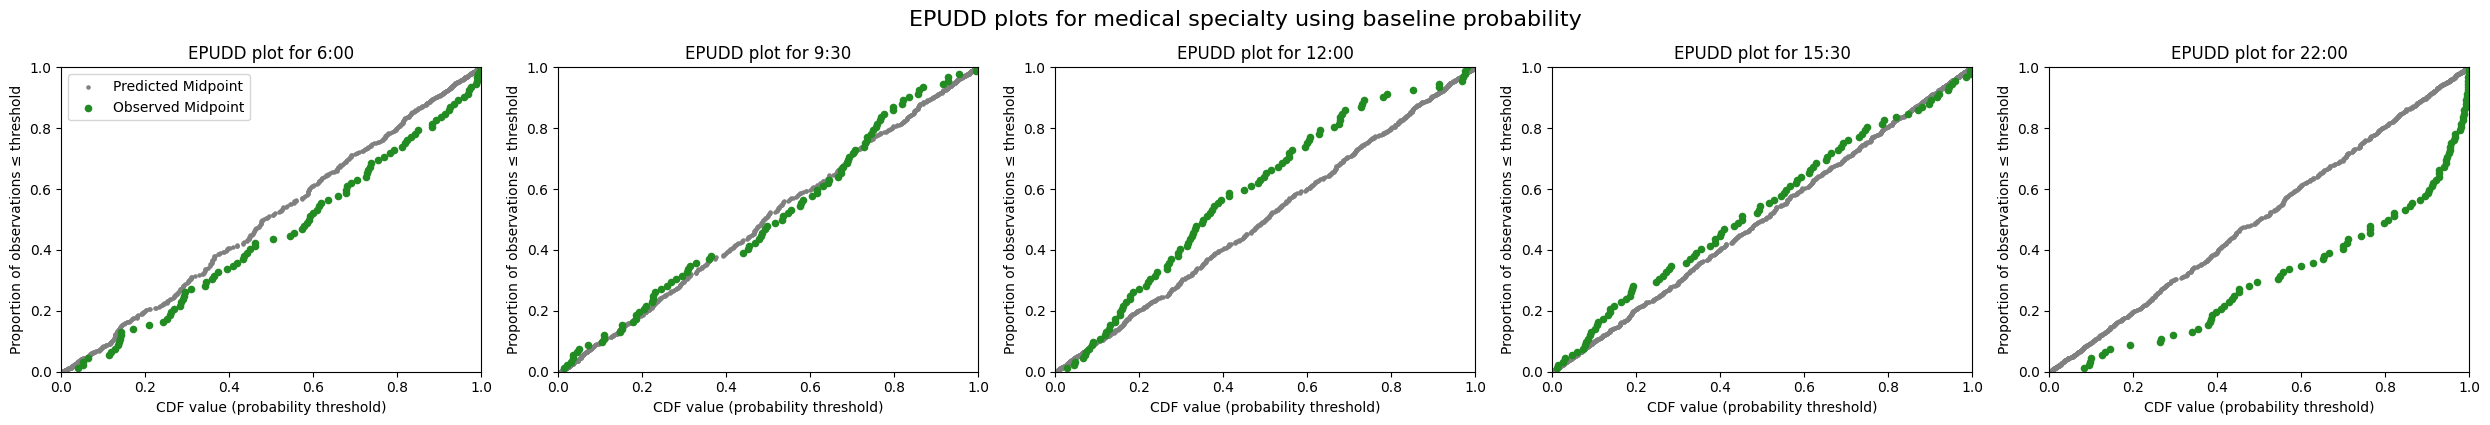

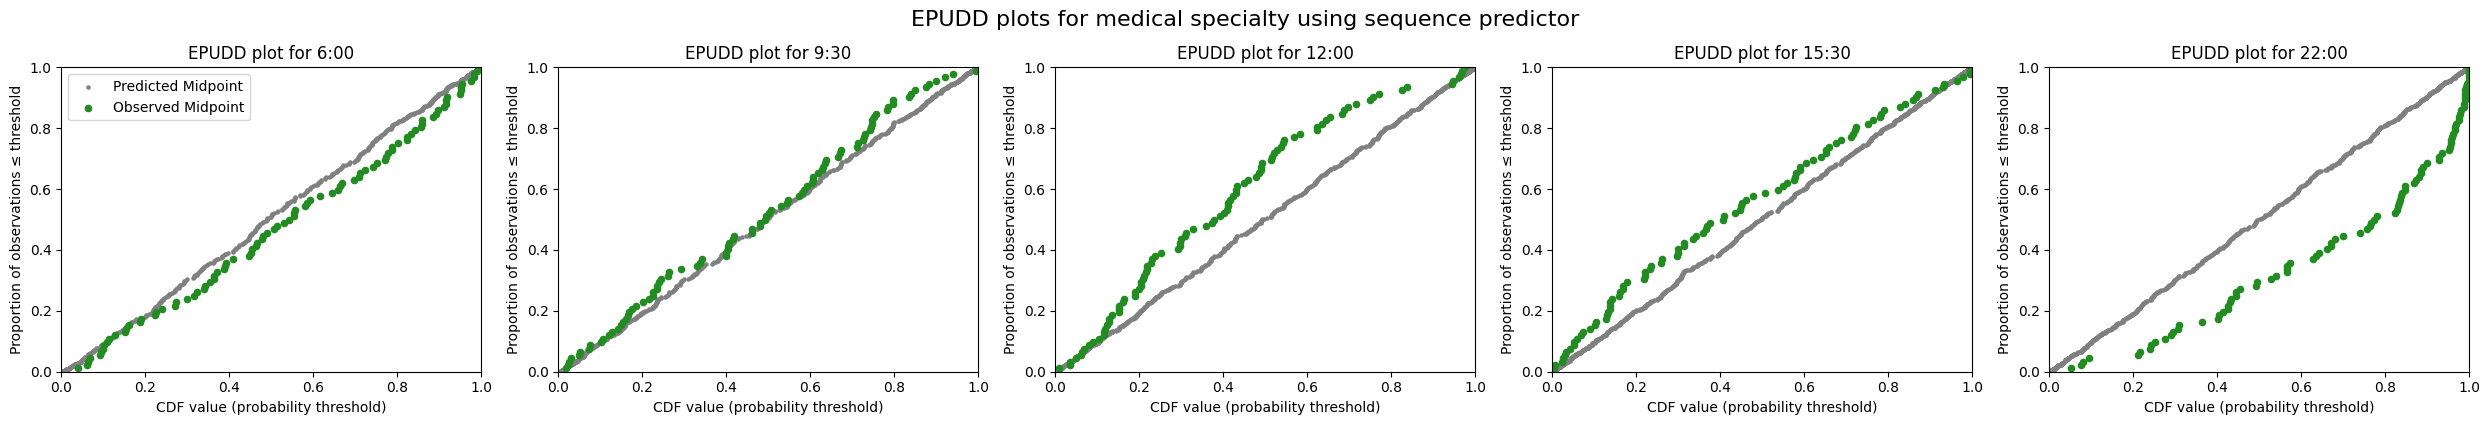


EPUDD plots for surgical specialty: baseline vs sequence predictor


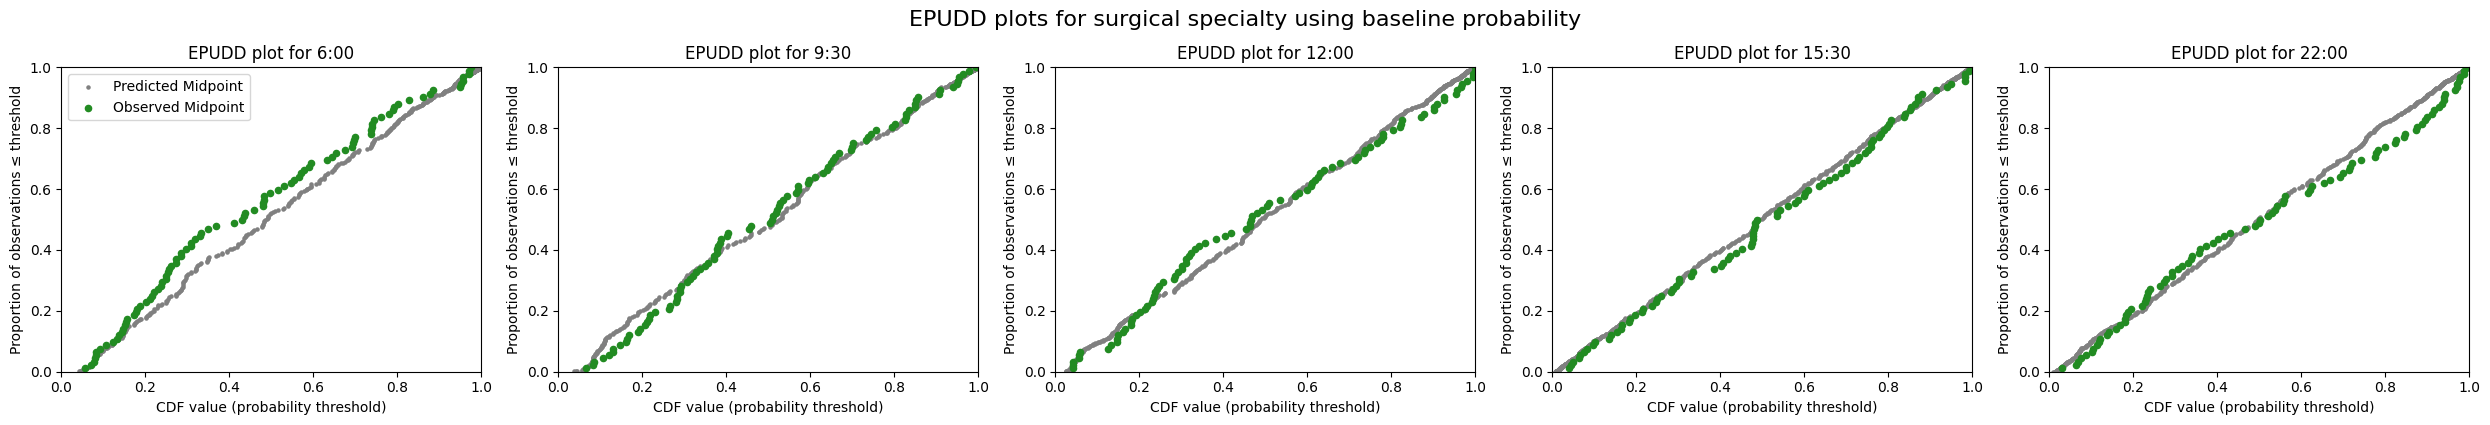

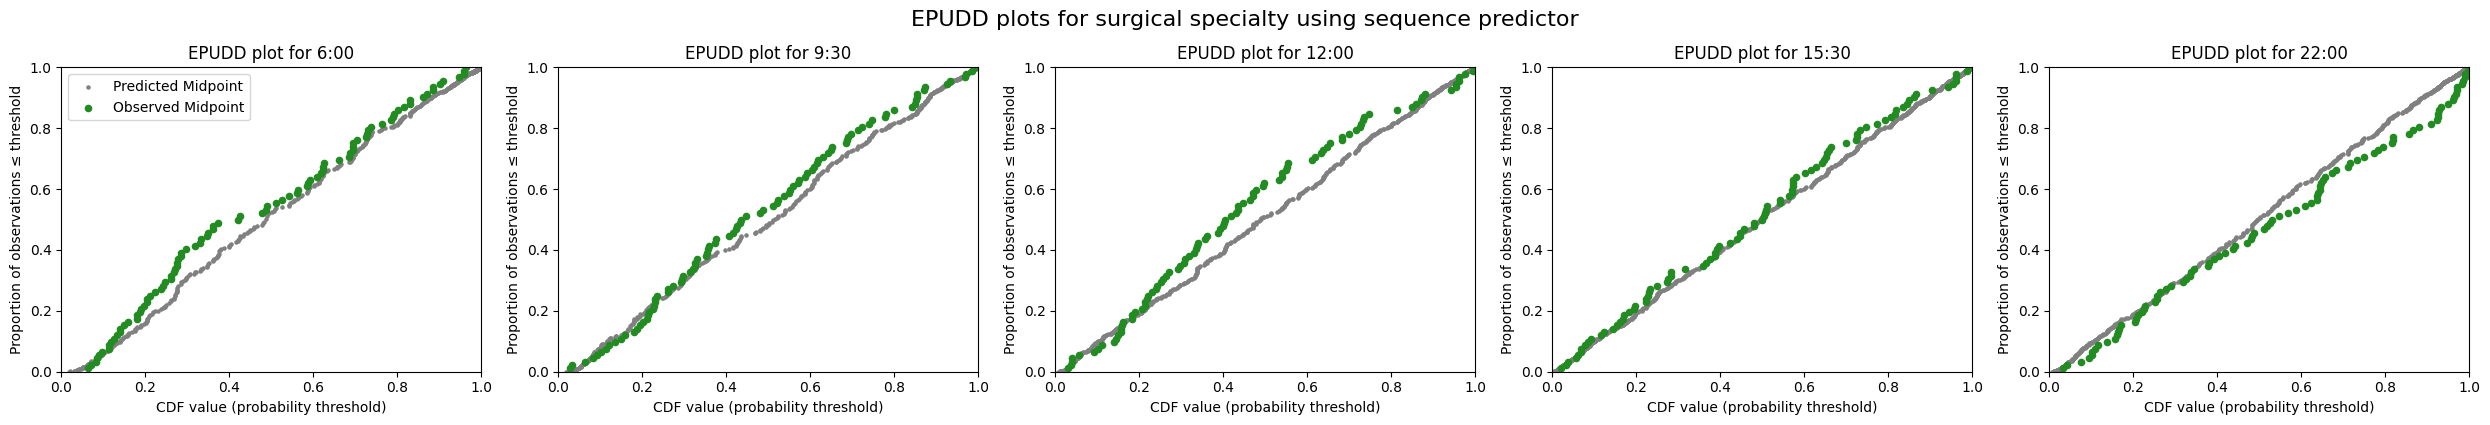


EPUDD plots for haem/onc specialty: baseline vs sequence predictor


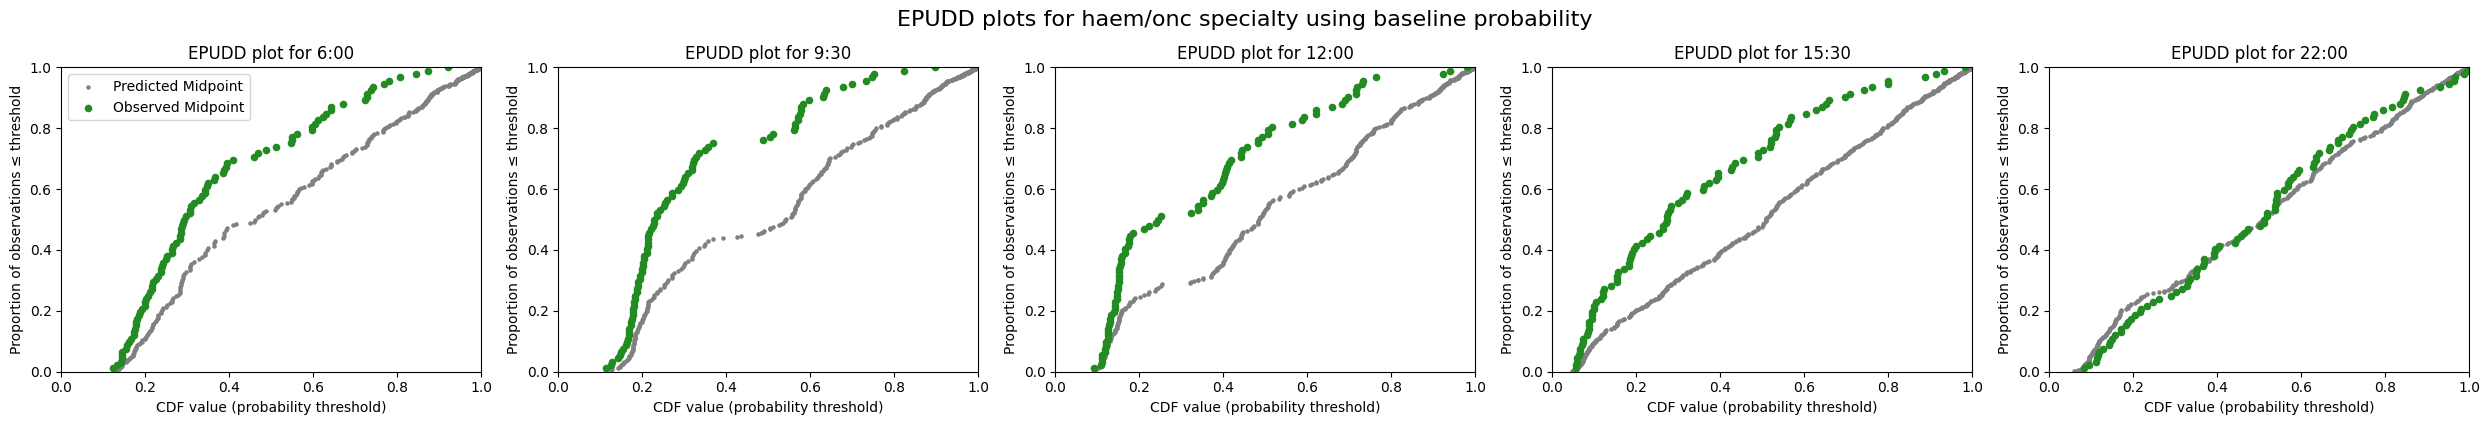

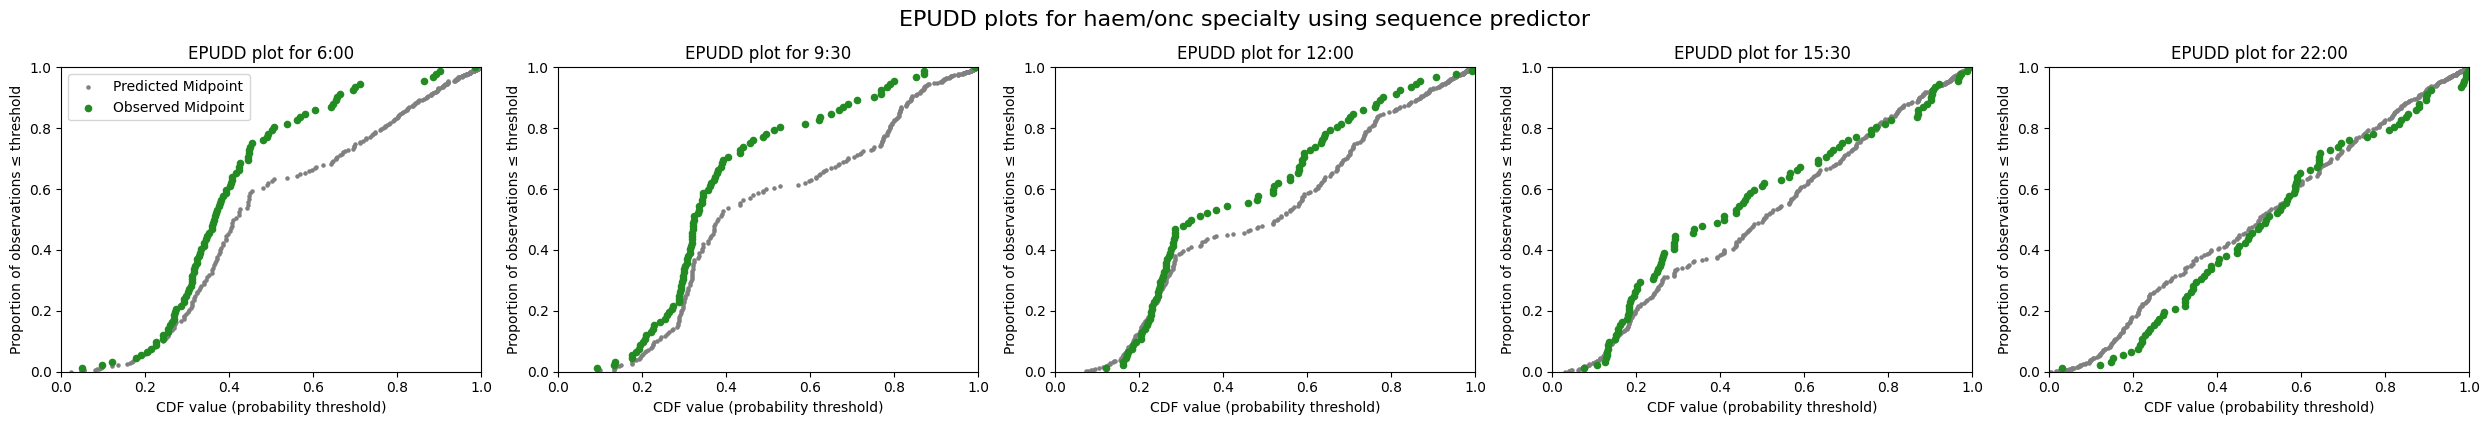


EPUDD plots for paediatric specialty: baseline vs sequence predictor


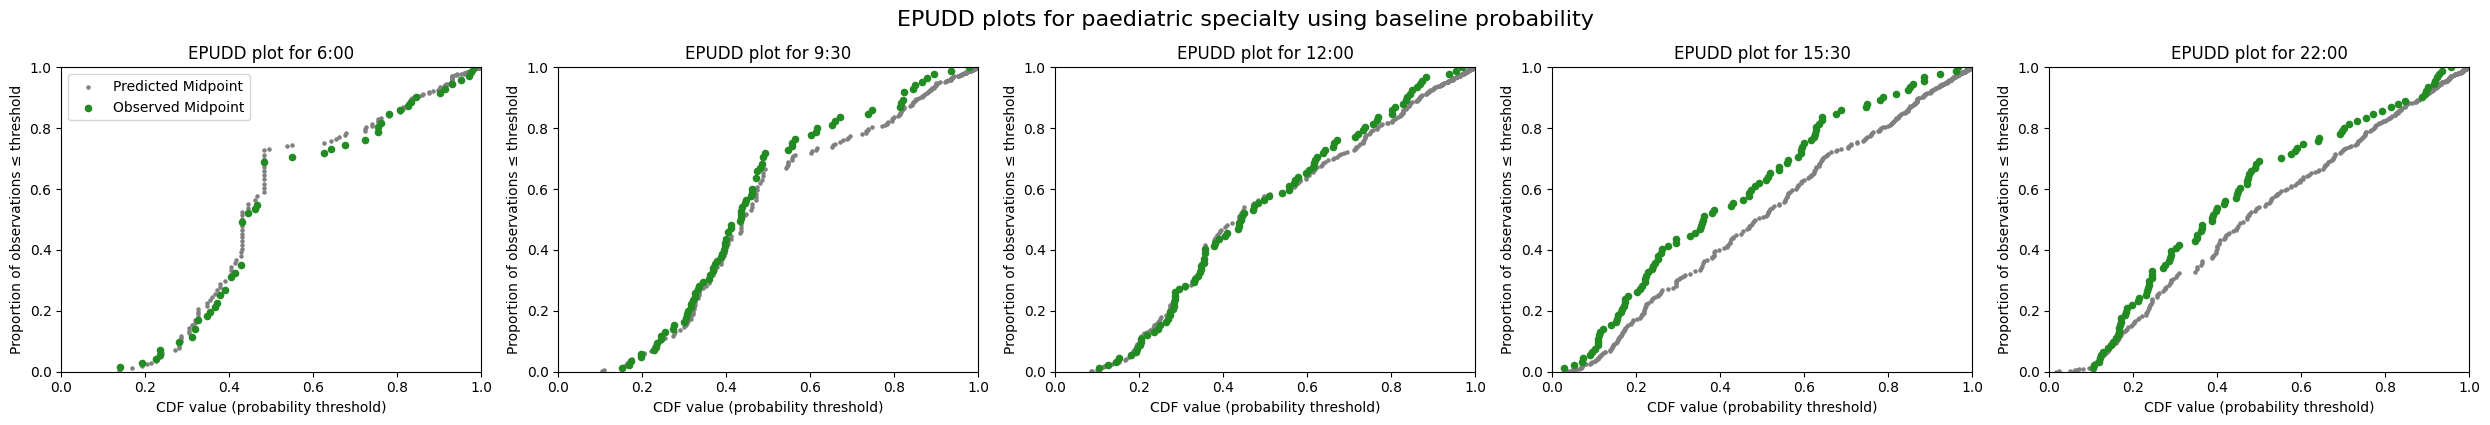

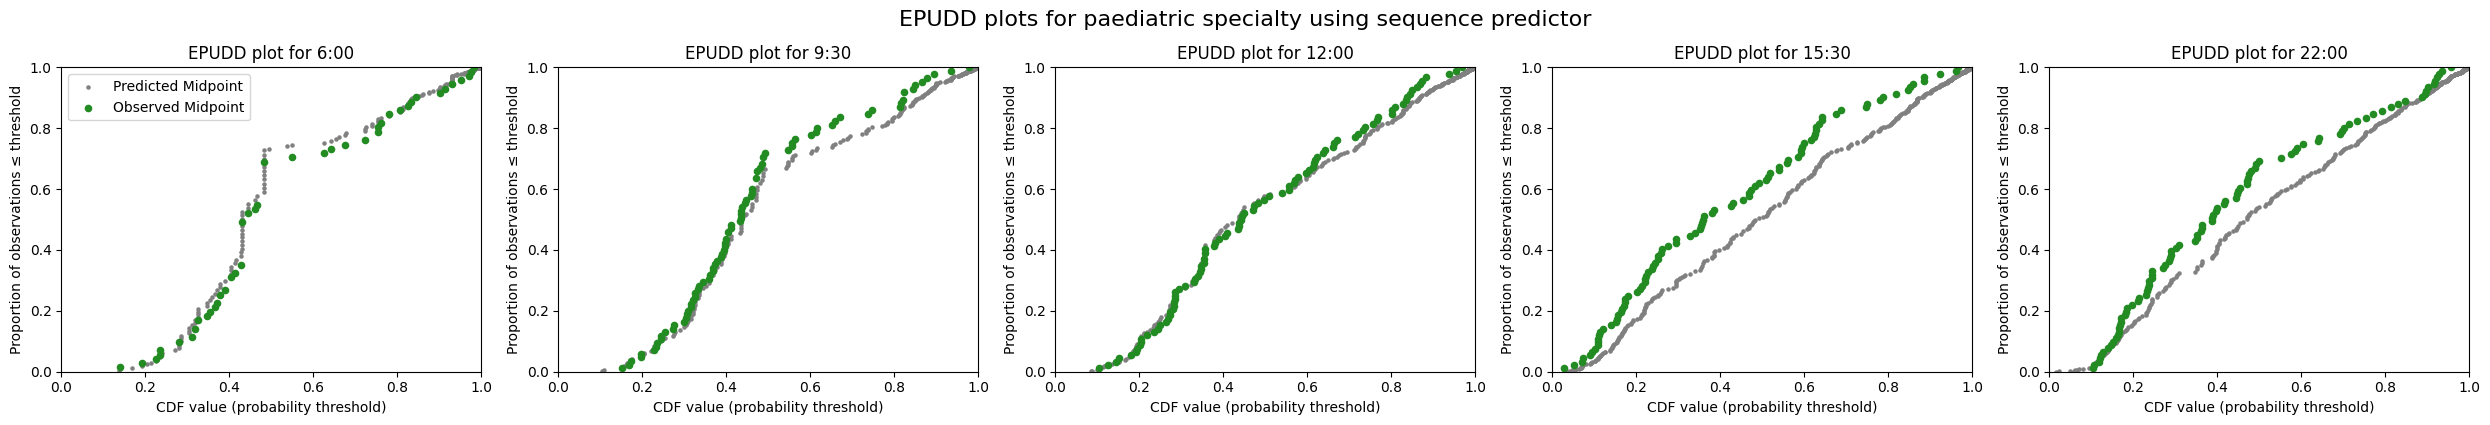

In [15]:
from patientflow.viz.epudd import plot_epudd

for specialty in ['medical', 'surgical', 'haem/onc', 'paediatric']:

    print(f'\nEPUDD plots for {specialty} specialty: baseline vs sequence predictor')

    specialty_prob_dist_baseline = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all_baseline.items()}
    specialty_prob_dist = {time: dist_dict[specialty] for time, dist_dict in prob_dist_dict_all.items()}

    plot_epudd(ed_visits.prediction_time.unique(), 
        specialty_prob_dist_baseline,
        model_name="admissions",
        suptitle=f"EPUDD plots for {specialty} specialty using baseline probability")
    
    plot_epudd(ed_visits.prediction_time.unique(), 
        specialty_prob_dist,
        model_name="admissions",
        suptitle=f"EPUDD plots for {specialty} specialty using sequence predictor")

## Summary

In this notebook I have shown how to specify that certain groups are handled differently. In the UCLH case, we assume that all patients under 18 will be admitted to a paediatric specialty. I have demonstrated how you can use the functions in patientflow to handle such special cases. 

Note: the approach illustrated here had been deprecated. The code will still work, but this notebook will be replaced in due course. 

## Appendix: Legacy approach for sub-group handling

The following sections show the legacy approach for handling sub-groups, maintained for backward compatibility. The modern approach uses `MultiSubgroupPredictor` as shown above.

## Train specialty model - legacy code

The legacy approach, prior to implementing the MultiSubgroupPredictor was, when training the model predicting specialty of admission, to set a `apply_special_category_filtering` parameter to True. The legacy approach has been included here for completeness.

## Changes required in your implementation

Listed below are the functions that relate to this special handling. However, note that the way this is handled has been deprecated, in favour of a more generalisable approach. 

1. **SpecialCategoryParams Class** (`src/patientflow/prepare.py`):
- Specialty names and flags in `special_category_dict`
- Age detection logic in `special_category_func`
- Category mapping in `special_func_map`

2. **SequenceToOutcomePredictor Class** (`src/patientflow/predictors/sequence_to_outcome_predictor.py`):
- Uses `create_special_category_objects` in `_preprocess_data`
- Filters data based on special categories
- Handles specialty predictions differently for special categories

3. **ValueToOutcomePredictor Class** (`src/patientflow/predictors/value_to_outcome_predictor.py`):
- Similar to SequenceToOutcomePredictor, uses special category filtering
- Applies the same filtering logic in `_preprocess_data`

4. **create_yta_filters Function** (`src/patientflow/prepare.py`):
- Creates specialty filters based on special category parameters
- Generates filter configurations for each specialty

5. **get_specialty_probs Function** (`src/patientflow/predict/emergency_demand.py`):
- Uses special category functions to determine specialty probabilities
- Applies different probability distributions for special categories

6. **create_predictions Function** (`src/patientflow/predict/emergency_demand.py`):
- Validates that requested specialties match special category dictionary
- Uses special function map for filtering predictions
- Applies different prediction logic for special categories

7. **WeightedPoissonPredictor Class** (`src/patientflow/predictors/weighted_poisson_predictor.py`):
- Uses specialty filters for predictions
- Handles different prediction logic for special categories

8. **Tests** (`tests/test_create_predictions.py`):
- Test cases for special category handling
- Validation of special category predictions

To modify your implementation for different specialty names and rules, you would need to:

1. Create a new class that inherits from `SpecialCategoryParams` with your custom logic
2. Update all the specialty names and flags in the special category dictionary
3. Modify the detection functions for your special categories
4. Update the filter configurations in `create_yta_filters`
5. Ensure all test cases are updated to reflect your new specialty structure
6. Update any documentation or examples that reference the specialty names


In [16]:
from patientflow.predictors.sequence_to_outcome_predictor import SequenceToOutcomePredictor

spec_model = SequenceToOutcomePredictor(
    input_var="consultation_sequence",
    grouping_var="final_sequence",
    outcome_var="specialty",
    apply_special_category_filtering=True,
)

spec_model = spec_model.fit(train_visits_df)

spec_model

SequenceToOutcomePredictor(
    input_var='consultation_sequence',
    grouping_var='final_sequence',
    outcome_var='specialty',
    apply_special_category_filtering=True,
    admit_col='is_admitted'
)

Under the hood, the `SequenceToOutcomePredictor` will call a `create_special_category_objects()` function that returns rules for how to handle each subgroup. The implementation here is primarily designed to handle paediatric patients (under 18) as a special category. A `SpecialCategoryParams` class generates a dictionary mapping specialties to flags (1.0 for paediatric, 0.0 for others) and functions to identify paediatric patients based on age data. It provides methods to handle both age formats (age_on_arrival or age_group). 

The `SequenceToOutcomePredictor` applies these rules during both training and prediction, ensuring consistent handling of special categories across the entire prediction pipeline

The `SpecialCategoryParams` class is designed to be picklable, which is necessary for saving the specialty predictor model to disk.

The output from `create_special_category_objects` is shown below. Note that the output is specific to the UCLH implementation, and that its use has been deprecated in favour of a more generalisable approach. 

See below for notes about how to change this for your implementation. 



In [17]:
from patientflow.prepare import create_special_category_objects
create_special_category_objects(train_visits_df.columns)

{'special_category_func': <function patientflow.predictors.subgroup_definitions._is_paediatric(row)>,
 'special_category_dict': {'medical': 0.0,
  'surgical': 0.0,
  'haem/onc': 0.0,
  'paediatric': 1.0},
 'special_func_map': {'paediatric': <function patientflow.predictors.subgroup_definitions._is_paediatric(row)>,
  'default': <function patientflow.predictors.subgroup_definitions._is_adult(row)>}}

### Saving of special category information

The `ParametricIncomingAdmissionPredictor` class uses the special category objects during initialisation to create static filters that map specialties to their configurations (e.g., {'is_child': True} for paediatric cases), but does not need them in the predict method. The filters are saved with the instance. 

In [18]:
yta_model_by_spec.filters

{'medical': {'specialty': 'medical', 'is_child': False},
 'surgical': {'specialty': 'surgical', 'is_child': False},
 'haem/onc': {'specialty': 'haem/onc', 'is_child': False},
 'paediatric': {'is_child': True}}

In contrast, the `SequenceToOutcomePredictor` save the special parameters as a function, which is used by the predict method to filter and categorise patients based on their characteristics.

In [19]:
spec_model.special_params

{'special_category_func': <function patientflow.predictors.subgroup_definitions._is_paediatric(row)>,
 'special_category_dict': {'medical': 0.0,
  'surgical': 0.0,
  'haem/onc': 0.0,
  'paediatric': 1.0},
 'special_func_map': {'paediatric': <function patientflow.predictors.subgroup_definitions._is_paediatric(row)>,
  'default': <function patientflow.predictors.subgroup_definitions._is_adult(row)>}}